# Detection Error Tradeoff 

In [1]:
import math
import operator
from pathlib import Path

from ipywidgets import fixed, interact
import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import describe, gaussian_kde
import seaborn as sns

import sys
sys.path.insert(0, '../../utils')
from DET_utils.DET import DET
from DET_utils.DET_plots import *



mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

## Load mated and non-mated similarity scores 

In [2]:
mated_scores1 = np.load('../mated_sim_scores_child_final.npy')
nonmated_scores1 = np.load('../nonmated_sim_scores_child_final.npy')
scores_type1 = "similarity"

mated_scores2 = np.load('../mated_sim_scores_adult_final.npy')
nonmated_scores2 = np.load('../nonmated_sim_scores_adult_final.npy')
scores_type2 = "similarity"


# mated_scores3 = np.load('../mated_sim_scores_canon_final.npy')
# nonmated_scores3 = np.load('../nonmated_sim_scores_canon_final.npy')
# scores_type3 = "similarity"

In [3]:
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
stats_system1_df.round(round_digits).style.hide_index()


/tmp/ipykernel_3592/2890155579.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  stats_system1_df.round(round_digits).style.hide_index()


Statistic,Mated,Non-mated
Observations,4018.000000,3916425.000000
Minimum,0.078510,-0.377520
Maximum,0.989440,0.984690
Mean,0.625240,0.144190
St. Dev.,0.151700,0.136130
Skewness,-0.356400,0.237970
Ex. Kurtosis,-0.186660,-0.076450


In [4]:
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
stats_system2_df.round(round_digits).style.hide_index()

/tmp/ipykernel_3592/1952787033.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  stats_system2_df.round(round_digits).style.hide_index()


Statistic,Mated,Non-mated
Observations,622.000000,7471268.000000
Minimum,-0.004130,-0.328600
Maximum,0.964100,0.803650
Mean,0.436890,0.203970
St. Dev.,0.150540,0.119210
Skewness,0.033750,0.025440
Ex. Kurtosis,0.191070,-0.023540


In [5]:
# stats_system3_df = descriptive_statistics(mated_scores3, nonmated_scores3)
# stats_system3_df.round(round_digits).style.hide_index()

# Similarity plots

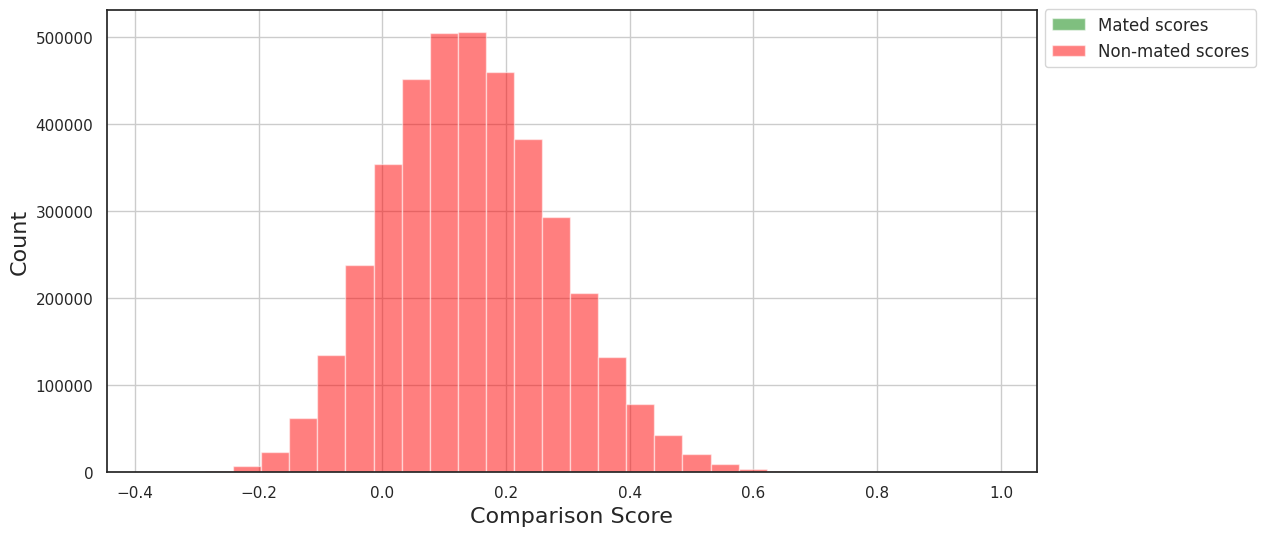

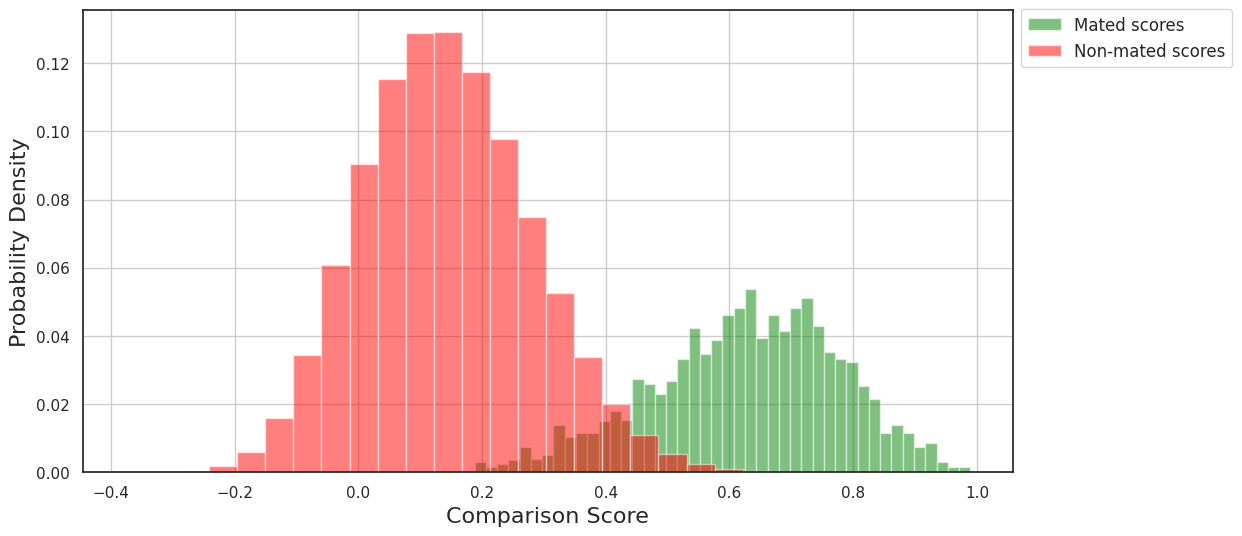

In [6]:
#children
plot_histogram(mated_scores1, nonmated_scores1, normalise=False)
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)

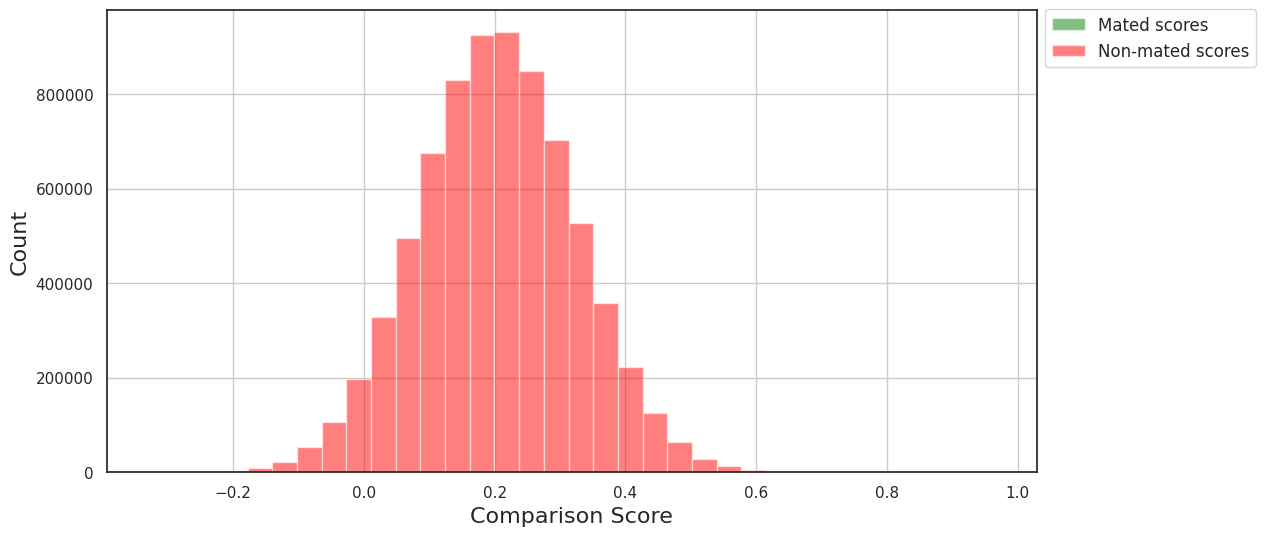

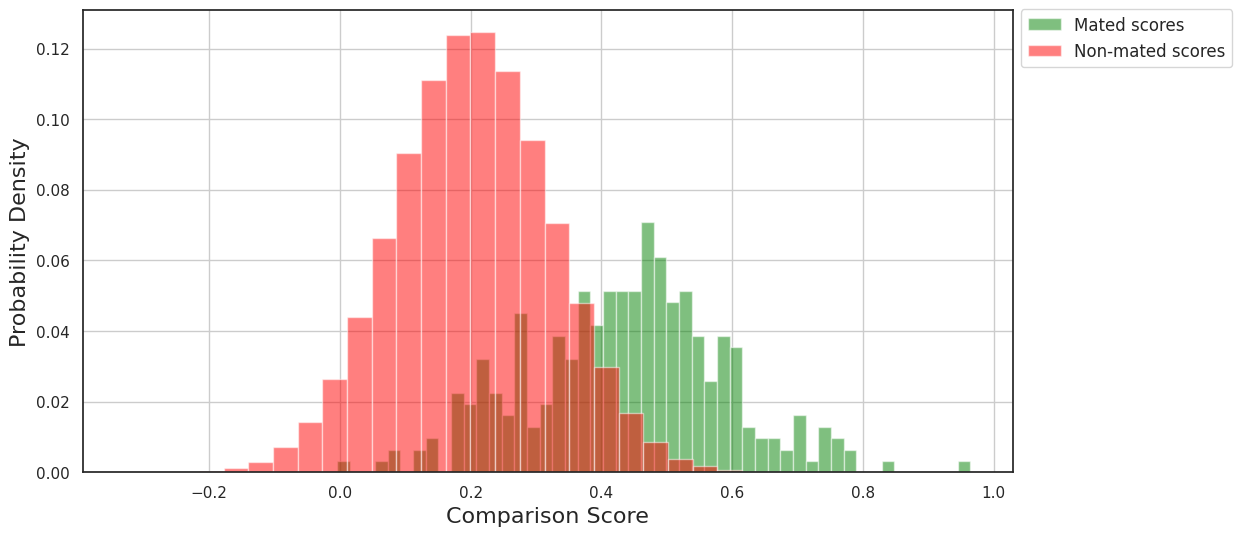

In [7]:
#adults
plot_histogram(mated_scores2, nonmated_scores2, normalise=False)
plot_histogram(mated_scores2, nonmated_scores2, normalise=True)

In [8]:
# #canonical
# plot_histogram(mated_scores3, nonmated_scores3, normalise=False)
# plot_histogram(mated_scores3, nonmated_scores3, normalise=True)

In [9]:
# canonical vs mixed
# NONMATED
# plot_histogram(nonmated_scores3, nonmated_scores1, normalise=True) # canonical nonmated vs nonmixed mated

In [10]:
# plot_histogram(mated_scores3, mated_scores1, normalise=True) # MATED: canonical mated vs mixed mated

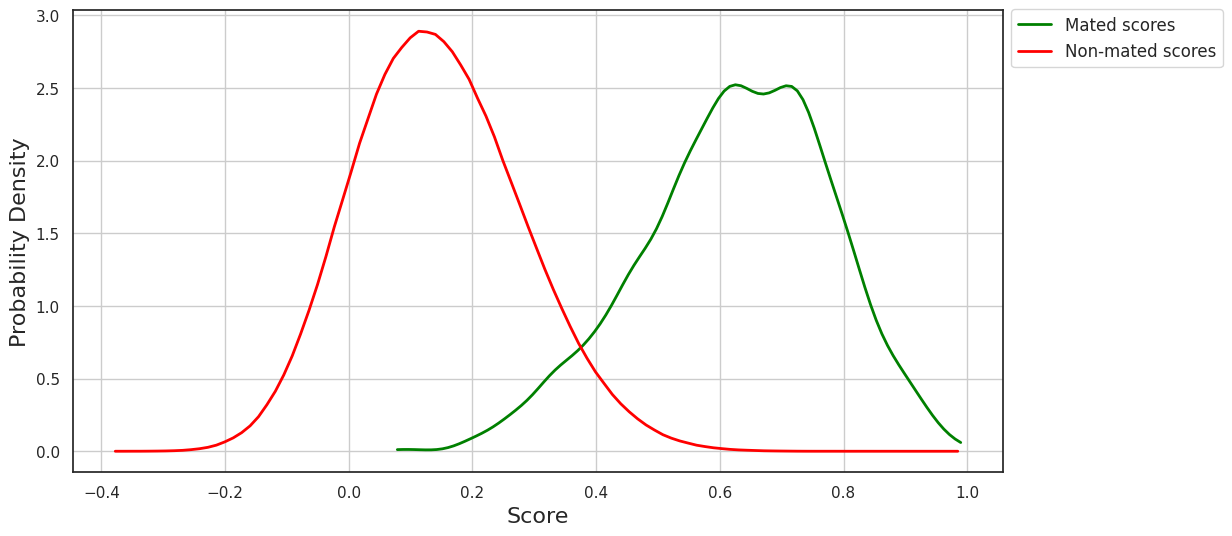

In [11]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()

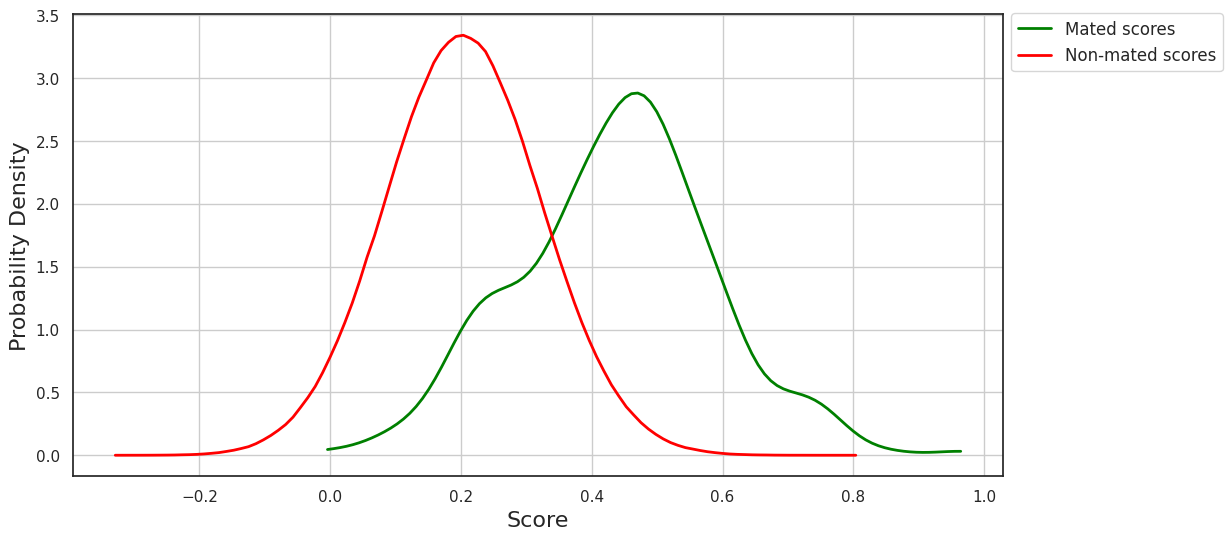

In [12]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores2)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores2)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()

In [13]:
# mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores3)
# nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores3)
# plt.figure(figsize=figure_size)
# plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
# plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
# plt.xlabel("Score", size=label_fontsize)
# plt.ylabel("Probability Density", size=label_fontsize)
# plt.grid(True)
# plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
# plt.show()

## Separability and Thresholding
There seems to be a decent separation (i.e. not much overlap) between the two score distributions above. We can quantify this using the so-called [sensitivity index](https://en.wikipedia.org/wiki/Sensitivity_index), which is a dimensionless metric which measures the separation between two distributions. Although it assumes the data is normally distributed (which is not always the case with biometric data) and does not take into account higher order moments (e.g. skewness and kurtosis), it can still give a reasonable approximate of how well the mated and non-mated scores are separated (larger value means better separation). It is computed as follows: $$d' = \frac{\|\mu_{mated} - \mu_{non-mated}\|}{\sqrt{\frac{1}{2}\left(\sigma_{mated}^2 + \sigma_{non-mated}^2\right)}}$$

In [14]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' child =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' adult =", round(d_prime_system2, round_digits))

# d_prime_system3 = d_prime(mated_scores3, nonmated_scores3)
# print("d' canonical =", round(d_prime_system3, round_digits))


d' child = 3.33798
d' adult = 1.7163


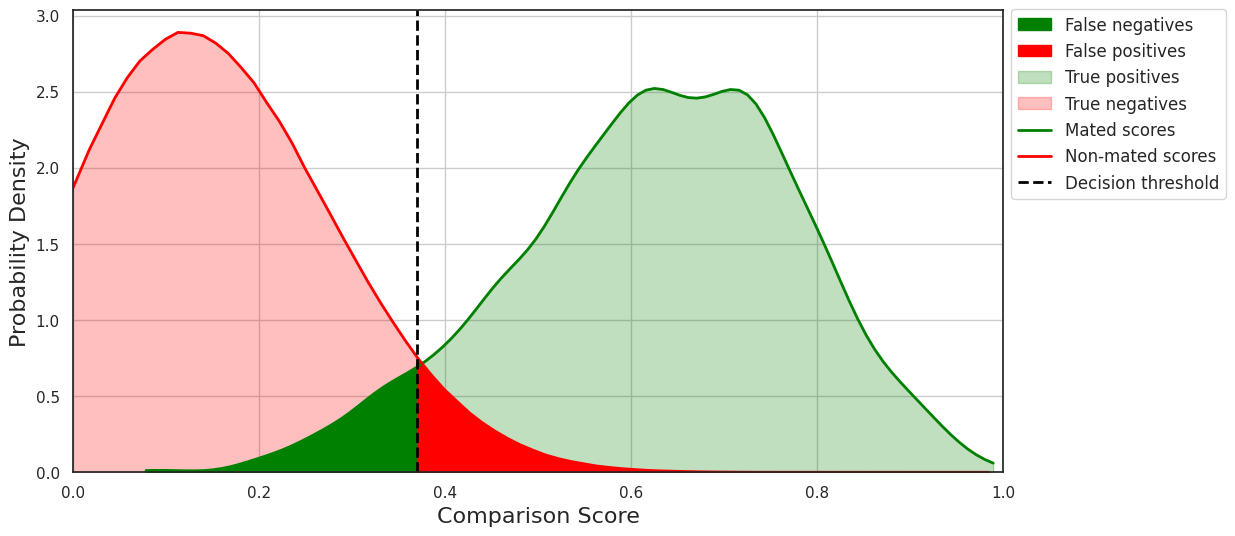

In [24]:
threshold1 = 0.37
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

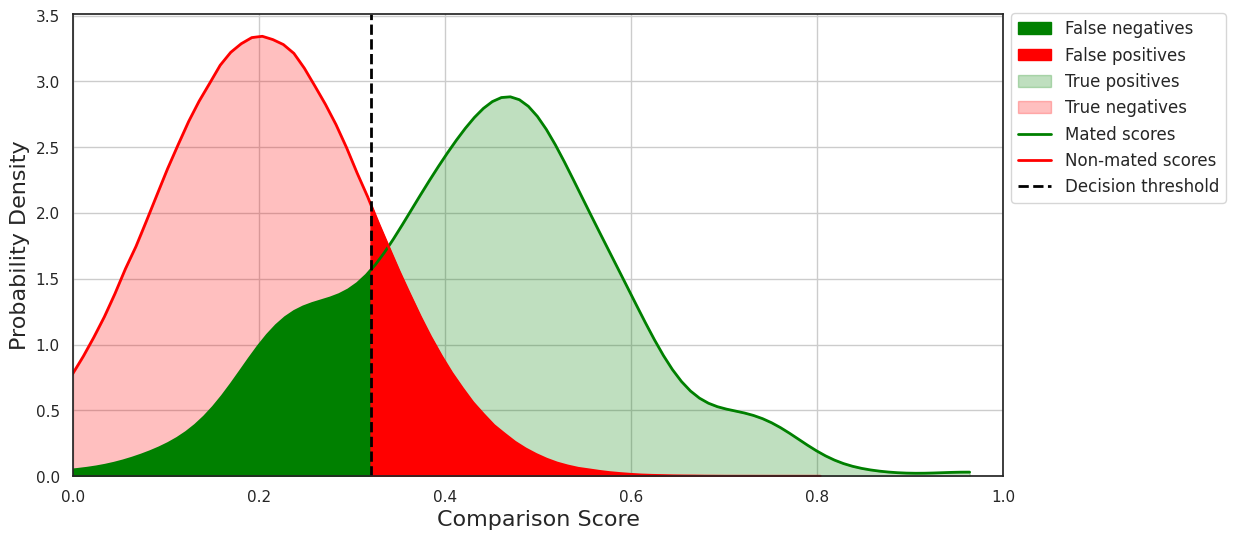

In [25]:
threshold2 = 0.32
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2)

In [17]:
# threshold1 = 0.4
# kde_with_threshold(mated_scores3, nonmated_scores3, scores_type3, threshold3)

# Confusion matrix

In [26]:
style_confusion_matrix(get_confusion_matrix(mated_scores1, nonmated_scores1, scores_type1, threshold1, mode="count"))

/mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/notebooks/data_vis/../../utils/DET_utils/DET_plots.py:223: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  return confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']]).hide_index()


Predicted/Actual,Mated,Non-mated
Mated,3762,219827
Non-mated,256,3696598


In [27]:
style_confusion_matrix(get_confusion_matrix(mated_scores1, nonmated_scores1, scores_type1, threshold1, mode="percent").round(round_digits))

/mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/notebooks/data_vis/../../utils/DET_utils/DET_plots.py:223: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  return confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']]).hide_index()


Predicted/Actual,Mated,Non-mated
Mated,93.628670,5.612950
Non-mated,6.371330,94.387050


# DET Curves

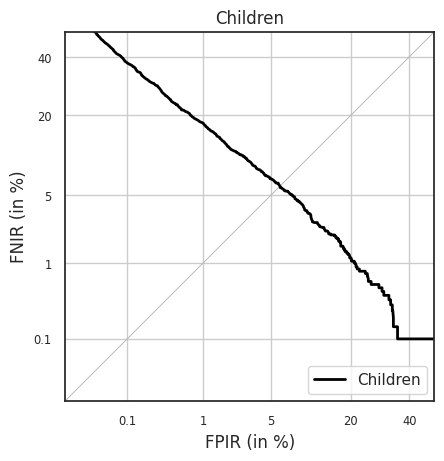

In [28]:
system_name1 = "Children"
system_name2 = "Adults"

det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.legend_on()
det.show()

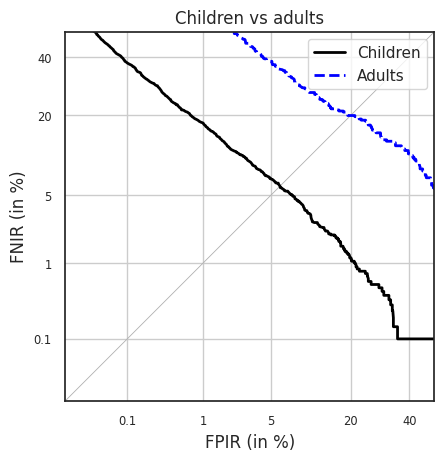

In [29]:
det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children vs adults")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
det.show()

In [22]:
# system_name1 = "Children Mixed"
# system_name2 = "Children Canonical"

# det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="Children canonical vs children mixed")
# det.x_limits = np.array([1e-4, .5])
# det.y_limits = np.array([1e-4, .5])
# det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
# det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
# det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
# det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
# det.create_figure()
# det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
# det.plot(tar=adjust_scores_for_DET(mated_scores3, scores_type3), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
# det.legend_on(loc="upper right")
# det.show()